In [1]:
import numpy as np
import pandas as pd
import requests
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigs

## Algorithms

In [2]:
# Algorithm 1
def CN_VEC(X, A, S, k):
    """
    X: array, Covariates of all nodes. For nodes which covariates are unknown array contains NaN
    A: array, Adjacency matrix of the graph (now weighted)
    S: array of indexes, Set of nodes with known covariates
    k: number of neighbors
    """
    all_nodes = set(np.arange(A.shape[0]))
    no_cov_nodes = all_nodes - set(S)
    X_hat = X.copy()
    C = A.dot(A).A
    
    for node_i in tqdm(no_cov_nodes):
        Ci = np.ones_like(C) * C[node_i]
        Ci[:, node_i] = 0
        np.fill_diagonal(Ci, 0)
        
        Cj = C.copy()
        Cj[:, node_i] = 0
        np.fill_diagonal(Cj, 0)
        
        dists = np.sum((Ci**2 - 2) * (Ci >= 2) + (Cj**2 - 2) * (Cj >= 2) - 2 * Ci * Cj, axis=1)[S]
        
        idxs = np.argsort(dists)[:k]
        ktop = np.array(S)[idxs]
        X_hat[node_i] = np.mean(X[ktop])
        
    return X_hat

In [3]:
# Algorithm 2
def SVD_RBF(X, A, S, theta, d):
    """
    X: array, Covariates of all nodes. For nodes which covariates are unknown array contains NaN
    A: array, Adjacency matrix of the graph (now weighted)
    S: array of indexes, Set of nodes with known covariates
    theta: bandwidth
    d: rank of matrix
    
    """

    E, U = eigs(A, d)
    V = np.real(U) * np.abs(np.real(E))**(1/2)
    
    all_nodes = set(np.arange(A.shape[0]))
    no_cov_nodes = np.array(list(all_nodes - set(S)))
    X_hat = X.copy()
    dists = rbf_kernel(V, V, gamma=1/2/(theta**2))
    X_hat[no_cov_nodes] = np.sum(dists[no_cov_nodes][:, S] * X[S], axis=1) / np.sum(dists[no_cov_nodes][:, S], axis=1)
        
    return X_hat

In [4]:
def NBR(X, A, S):
    all_nodes = set(np.arange(A.shape[0]))
    no_cov_nodes = np.array(list(all_nodes - set(S)))
    X_hat = X.copy()
    neighbors = np.sum(A.A[no_cov_nodes][:, S], axis=1)
    
    X_hat[no_cov_nodes] = np.divide(np.sum(A.A[no_cov_nodes][:, S] * X[S], axis=1), neighbors, where=neighbors>0)
        
    return X_hat

In [5]:
def W_PPR(X, A, S, k):
    all_nodes = set(np.arange(A.shape[0]))
    no_cov_nodes = np.array(list(all_nodes - set(S)))
    X_hat = X.copy()
    
    gamma = np.exp(-.25)
    D = np.diag(A.dot(np.ones(A.shape[0])))
    D_inv = np.divide(1, D, where=D>0)
    M = (1 - gamma) * np.linalg.inv(np.eye(D.shape[0]) - gamma * A.dot(D_inv))
    W = (M + M.T) / 2
    
    neighbors = np.argsort(W[no_cov_nodes][:, S], axis=1)[:, -k:]
    weights = np.sum(np.take(W[no_cov_nodes][:, S], neighbors), axis=1)
    X_hat[no_cov_nodes] = np.divide(np.sum(np.take(W[no_cov_nodes][:, S]*X[S], neighbors), axis=1), weights, where=weights>0)
        
    return X_hat

In [6]:
def Jaccard(X, A, S, k):
    all_nodes = set(np.arange(A.shape[0]))
    no_cov_nodes = np.array(list(all_nodes - set(S)))
    X_hat = X.copy()
    C = A.dot(A)
    d = A.dot(np.outer(np.ones(A.shape[0]), np.ones(A.shape[0])))
    W = np.array(C / (d + d.T - C))
    
    neighbors = np.argsort(W[no_cov_nodes][:, S], axis=1)[:, -k:]
    weights = np.sum(np.take(W[no_cov_nodes][:, S], neighbors), axis=1)
    X_hat[no_cov_nodes] = np.divide(np.sum(np.take(W[no_cov_nodes][:, S]*X[S], neighbors), axis=1), weights, where=weights>0)
       
    return X_hat

In [7]:
def CN(X, A, S, k):
    all_nodes = set(np.arange(A.shape[0]))
    no_cov_nodes = np.array(list(all_nodes - set(S)))
    X_hat = X.copy()
    
    W = A.dot(A).A
    
    neighbors = np.argsort(W[no_cov_nodes][:, S], axis=1)[:, -k:]
    weights = np.sum(np.take(W[no_cov_nodes][:, S], neighbors), axis=1)
    X_hat[no_cov_nodes] = np.divide(np.sum(np.take(W[no_cov_nodes][:, S]*X[S], neighbors), axis=1), weights, where=weights>0)
       
    return X_hat

### Tests

#### Artificial

In [38]:
A = csr_matrix(np.array([[0,1,1,0,1],[1,0,1,1,1],[1,1,0,1,1],[0,1,1,0,1],[1,1,1,1,0]], dtype=np.float64))

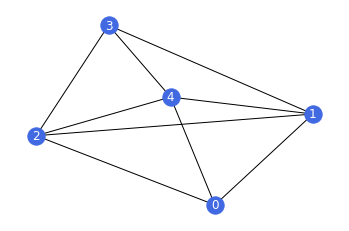

In [39]:
G = nx.from_numpy_array(A)
nx.draw_networkx(G, node_color='royalblue', font_color='white')
plt.axis('off');

In [40]:
X = np.array([np.nan,3,1,np.nan,2])
S = [1,2,4]
k = 2

In [41]:
CN_VEC(X, A, S, k)

  0%|          | 0/2 [00:00<?, ?it/s]

array([2., 3., 1., 2., 2.])

In [42]:
SVD_RBF(X, A, S, 1.5, k)

array([2., 3., 1., 2., 2.])

In [43]:
NBR(X, A, S)

array([2., 3., 1., 2., 2.])

In [71]:
W_PPR(X, A, S, k)

[[ 0.15111021 -0.0361464  -0.0361464  -0.070089   -0.0361464 ]
 [-0.0361464   0.2102298  -0.09385766 -0.0361464  -0.09385766]
 [-0.0361464  -0.09385766  0.2102298  -0.0361464  -0.09385766]
 [-0.070089   -0.0361464  -0.0361464   0.15111021 -0.0361464 ]
 [-0.0361464  -0.09385766 -0.09385766 -0.0361464   0.2102298 ]]


array([1.5, 3. , 1. , 1.5, 2. ])

In [76]:
Jaccard(X, A, S, k)

array([1.5, 3. , 1. , 1.5, 2. ])

In [98]:
CN(X, A, S, k)

array([2.5, 3. , 1. , 2.5, 2. ])

In [99]:
Node2Vec(X, A, S, 1.5, k)

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


  0%|          | 0/2 [00:00<?, ?it/s]

array([1.5, 3. , 1. , 2. , 2. ])

#### Real

In [78]:
data = pd.read_csv("drive_ru_short.csv")

In [79]:
data.head()

,brand,model,modif,price_from,price_to,price,year,new,mileage,region,wheel,actuator,horsepower,engine,volume,transmission,speeds,concat
0,Aston Martin,DB11 Coupe,V8,17800000,21000000,NaN,2016,True,0,Russia,NaN,задний,510,бензиновый,3982,автоматическая,8,Aston Martin DB11 Coupe V8
1,Aston Martin,DB11 Coupe,AMR V12,17800000,21000000,NaN,2016,True,0,Russia,NaN,задний,639,бензиновый,5204,автоматическая,8,Aston Martin DB11 Coupe AMR V12
2,Aston Martin,DB11 Volante,V8,18400000,18400000,18400000.0,2016,True,0,Russia,NaN,задний,510,бензиновый,3982,автоматическая,8,Aston Martin DB11 Volante V8
3,Aston Martin,DBX,V8,18245000,18245000,18245000.0,2019,True,0,Russia,NaN,полный,550,бензиновый,3982,автоматическая,9,Aston Martin DBX V8
4,Aston Martin,Vantage Coupe,V8,12900000,12900000,12900000.0,2017,True,0,Russia,NaN,задний,510,бензиновый,3982,автоматическая,8,Aston Martin Vantage Coupe V8


In [262]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         2091 non-null   object 
 1   model         2091 non-null   object 
 2   modif         2091 non-null   object 
 3   price_from    2091 non-null   int64  
 4   price_to      2091 non-null   int64  
 5   price         69 non-null     float64
 6   year          2091 non-null   int64  
 7   new           2091 non-null   bool   
 8   mileage       2091 non-null   int64  
 9   region        2091 non-null   object 
 10  wheel         0 non-null      float64
 11  actuator      2091 non-null   object 
 12  horsepower    2091 non-null   int64  
 13  engine        2091 non-null   object 
 14  volume        2091 non-null   int64  
 15  transmission  2091 non-null   object 
 16  speeds        2091 non-null   int64  
 17  concat        2091 non-null   object 
dtypes: bool(1), float64(2), int6

In [80]:
A = np.zeros((data.shape[0], data.shape[0]))

In [81]:
for i, row in enumerate(data):
    A[i][data[(data.brand == data.iloc[i].brand)|\
         (data.model == data.iloc[i].model)|\
         (data.year == data.iloc[i].year)|\
         (data.actuator == data.iloc[i].actuator)|\
         ((np.abs(data.horsepower - data.iloc[i].horsepower) < 10)&\
         (data.engine == data.iloc[i].engine)&\
         (np.abs(data.volume - data.iloc[i].volume) < 10))|\
         ((data.transmission == data.iloc[i].transmission)&\
         (data.speeds == data.iloc[i].speeds))].index] = 1

In [82]:
np.fill_diagonal(A, 0)
A = csr_matrix(A)

#### Predict price

In [83]:
X = data['price'].values
S = data[~data.price.isna()].index.values

In [84]:
k = 10
n = data.shape[0]
d = 5
# theta=0.04

In [107]:
nbr_pred = NBR(X, A, S)
# svd_pred = SVD_RBF(X, A, S, theta*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d)

In [97]:
wppr_pred = W_PPR(X, A, S, k)


In [98]:
jac_pred = Jaccard(X, A, S, k)


In [99]:
cn_pred = CN(X, A, S, k)

In [100]:
cn_vec_pred = CN_VEC(X, A, S, k)

  0%|          | 0/2022 [00:00<?, ?it/s]

In [108]:
data[(data.price.isna())&((data['price_from'] <= nbr_pred)&(nbr_pred<=data['price_to']))].shape[0]

0

In [102]:
data[(data.price.isna())&((data['price_from'] <= wppr_pred)&(wppr_pred<=data['price_to']))].shape[0]

0

In [103]:
data[(data.price.isna())&((data['price_from'] <= jac_pred)&(jac_pred<=data['price_to']))].shape[0]

201

In [104]:
data[(data.price.isna())&((data['price_from'] <= cn_pred)&(cn_pred<=data['price_to']))].shape[0]

193

In [105]:
data[(data.price.isna())&((data['price_from'] <= cn_vec_pred)&(cn_vec_pred<=data['price_to']))].shape[0]

193

In [135]:
grid = np.linspace(0.01, 1, 100)[5:]
d = np.arange(2, 9)

In [136]:
grid = list(zip(np.meshgrid(grid, d)[0].flatten(), np.meshgrid(grid, d)[1].flatten()))

In [139]:
correct = []
for theta, d in grid:
    answer = SVD_RBF(X, A, S, theta*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d)
    corr = data[(data.price.isna())&((data['price_from'] <= answer)&(answer<=data['price_to']))].shape[0]
    correct.append(corr)

In [143]:
np.unique(correct)

array([105, 106, 107])

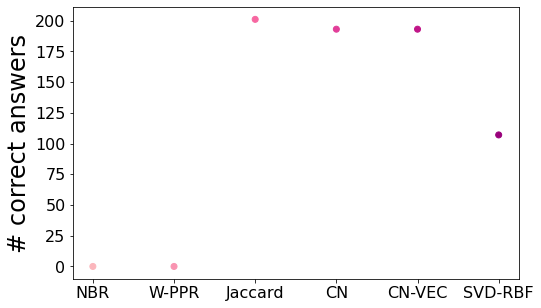

In [199]:
methods = ['NBR', 'W-PPR', 'Jaccard', 'CN', 'CN-VEC', 'SVD-RBF']
plt.figure(figsize=(8,5))
# plt.title('LSM', fontsize=24)
plt.ylabel('# correct answers', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.scatter(methods, [0, 0, 201, 193, 193, 107], c=plt.cm.RdPu(np.arange(1, 7)*0.1+0.2));

#### Predict price from

In [208]:
X = data['price_from'].values

In [231]:
k = 10
n = data.shape[0]
d = 3
shares = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

In [247]:
RMSE_NBRs = []
RMSE_W_PPRs = []
RMSE_Jaccards = []
RMSE_CNs = []
RMSE_SVD_RBFs = []
RMSE_CN_VECs = []
for share in shares:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_NBR = mean_squared_error(X, np.clip(NBR(X, A, S), 0, None), squared=False)
    RMSE_NBRs.append(RMSE_NBR)
#     print('NBR done')
    RMSE_W_PPR = mean_squared_error(X, np.clip(W_PPR(X, A, S, k), 0, None), squared=False)
    RMSE_W_PPRs.append(RMSE_W_PPR)
#     print('W_PPR done')
    RMSE_Jaccard = mean_squared_error(X, np.clip(Jaccard(X, A, S, k), 0, None), squared=False)
    RMSE_Jaccards.append(RMSE_Jaccard)
#     print('Jaccard done')
    RMSE_CN = mean_squared_error(X, np.clip(CN(X, A, S, k), 0, None), squared=False)
    RMSE_CNs.append(RMSE_CN)
#     print('CN done')
    RMSE_SVD_RBF = mean_squared_error(X, np.clip(SVD_RBF(X, A, S, 0.34*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), 0, None), squared=False)
    RMSE_SVD_RBFs.append(RMSE_SVD_RBF)
#     print('SVD RBF done')
    RMSE_CN_VEC = mean_squared_error(X, np.clip(CN_VEC(X, A, S, k), 0, None), squared=False)
    RMSE_CN_VECs.append(RMSE_CN_VEC)
# #     print('CN VEC done')
    print(share, 'done')

C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


  0%|          | 0/1046 [00:00<?, ?it/s]

0.5 done


C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


  0%|          | 0/1255 [00:00<?, ?it/s]

0.6 done


C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


  0%|          | 0/1464 [00:00<?, ?it/s]

0.7 done


C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


  0%|          | 0/1673 [00:00<?, ?it/s]

0.8 done


C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


  0%|          | 0/1882 [00:00<?, ?it/s]

0.9 done


In [257]:
RMSE_W_PPRs = []
for share in shares:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_W_PPR = mean_squared_error(X, np.clip(W_PPR(X, A, S, k), 0, None), squared=False)
    RMSE_W_PPRs.append(RMSE_W_PPR)

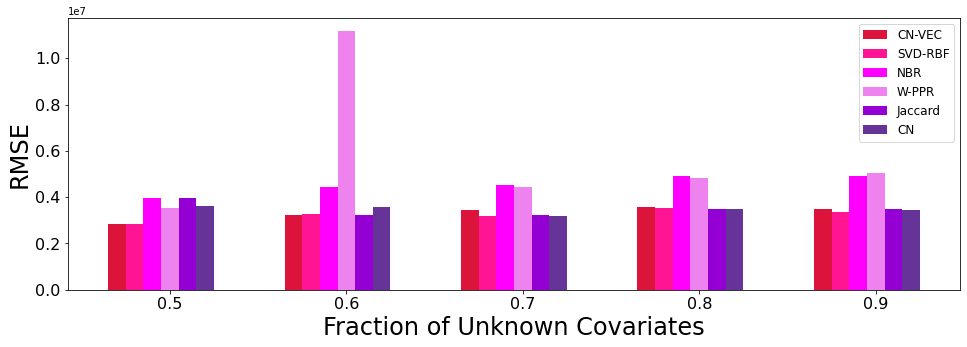

In [258]:
plt.figure(figsize=(16,5))
# plt.title('LSM', fontsize=24)
plt.xlabel('Fraction of Unknown Covariates', fontsize=24)
plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
width = 0.01
plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='crimson')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='deeppink')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='fuchsia')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='violet')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='darkviolet')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='rebeccapurple');
plt.legend(fontsize=12);

In [213]:
nbr_pred = NBR(X, A, S)
# svd_pred = SVD_RBF(X, A, S, theta*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d)

In [97]:
wppr_pred = W_PPR(X, A, S, k)


In [98]:
jac_pred = Jaccard(X, A, S, k)


In [99]:
cn_pred = CN(X, A, S, k)

In [100]:
cn_vec_pred = CN_VEC(X, A, S, k)

  0%|          | 0/2022 [00:00<?, ?it/s]

In [108]:
data[(data.price.isna())&((data['price_from'] <= nbr_pred)&(nbr_pred<=data['price_to']))].shape[0]

0

In [102]:
data[(data.price.isna())&((data['price_from'] <= wppr_pred)&(wppr_pred<=data['price_to']))].shape[0]

0

In [103]:
data[(data.price.isna())&((data['price_from'] <= jac_pred)&(jac_pred<=data['price_to']))].shape[0]

201

In [104]:
data[(data.price.isna())&((data['price_from'] <= cn_pred)&(cn_pred<=data['price_to']))].shape[0]

193

In [105]:
data[(data.price.isna())&((data['price_from'] <= cn_vec_pred)&(cn_vec_pred<=data['price_to']))].shape[0]

193

In [215]:
grid = np.linspace(0.01, 1, 100)[5:]
d = np.arange(2, 9)

In [216]:
grid = list(zip(np.meshgrid(grid, d)[0].flatten(), np.meshgrid(grid, d)[1].flatten()))

In [224]:
RMSE_SVD_RBFs = np.zeros((len(grid), 5))
for i, params in enumerate(grid):
    theta, d = params
    rmse = []
    for share in shares:
        S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
        try:
            RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, theta*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
        except:
            RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, theta*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
        rmse.append(RMSE_SVD_RBF)
    RMSE_SVD_RBFs[i] = rmse

In [230]:
np.array(grid)[np.argmin(RMSE_SVD_RBFs.mean(1))]

array([0.34, 3.  ])

## Experiments

In [43]:
n = 2500
d = 5

### Latent Space Model (LSM)

In [91]:
Z = np.random.uniform(0, 1, size=(n, d))

In [92]:
rho = 1
P = np.zeros((n,n))
for i in range(n):
    P[i] = rho / (1 + np.exp(2.5 * np.sqrt(np.sum((Z - Z[i])**2, axis=1))))

In [93]:
A = csr_matrix(np.random.binomial(1, P, (n,n)).astype(float))
A.setdiag(0)
A.eliminate_zeros()

C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [94]:
beta = np.random.normal(0, 1, (d,1))
beta = beta / np.linalg.norm(beta)
X = (Z @ beta).flatten() + np.random.normal(0, .1, (n,))

#### Available algorithms

In [44]:
k=10
shares = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

In [96]:
RMSE_NBRs = []
RMSE_W_PPRs = []
RMSE_Jaccards = []
RMSE_CNs = []
RMSE_SVD_RBFs = []
RMSE_CN_VECs = []
for share in shares:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_NBR = mean_squared_error(X, NBR(X, A, S), squared=False)
    RMSE_NBRs.append(RMSE_NBR)
#     print('NBR done')
    RMSE_W_PPR = mean_squared_error(X, W_PPR(X, A, S, k), squared=False)
    RMSE_W_PPRs.append(RMSE_W_PPR)
#     print('W_PPR done')
    RMSE_Jaccard = mean_squared_error(X, Jaccard(X, A, S, k), squared=False)
    RMSE_Jaccards.append(RMSE_Jaccard)
#     print('Jaccard done')
    RMSE_CN = mean_squared_error(X, CN(X, A, S, k), squared=False)
    RMSE_CNs.append(RMSE_CN)
#     print('CN done')
    RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, 0.04*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
    RMSE_SVD_RBFs.append(RMSE_SVD_RBF)
#     print('SVD RBF done')
    RMSE_CN_VEC = mean_squared_error(X, CN_VEC(X, A, S, k), squared=False)
    RMSE_CN_VECs.append(RMSE_CN_VEC)
# #     print('CN VEC done')
    print(share, 'done')

  0%|          | 0/1250 [00:00<?, ?it/s]

0.5 done


  0%|          | 0/1500 [00:00<?, ?it/s]

0.6 done


  0%|          | 0/1750 [00:00<?, ?it/s]

0.7 done


  0%|          | 0/2001 [00:00<?, ?it/s]

0.8 done


  0%|          | 0/2251 [00:00<?, ?it/s]

0.9 done


In [115]:
RMSE_SVD_RBFs = []
for share in shares:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, 0.04*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
    RMSE_SVD_RBFs.append(RMSE_SVD_RBF)

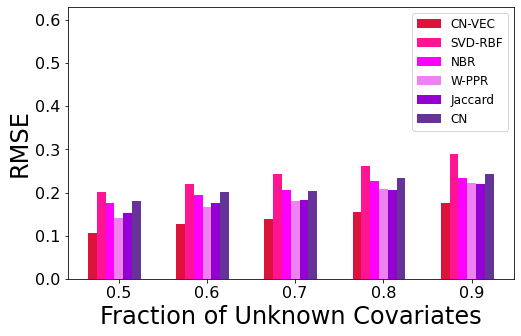

In [116]:
plt.figure(figsize=(8,5))
# plt.title('LSM', fontsize=24)
plt.xlabel('Fraction of Unknown Covariates', fontsize=24)
plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.63)
width = 0.01
plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='crimson')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='deeppink')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='fuchsia')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='violet')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='darkviolet')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='rebeccapurple');
plt.legend(fontsize=12);

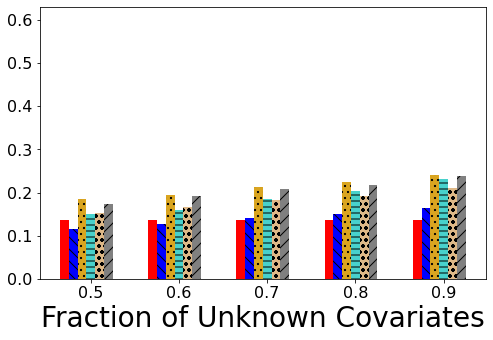

In [44]:
plt.figure(figsize=(8,5))
# plt.title('LSM')
plt.xlabel('Fraction of Unknown Covariates', fontsize=28)
# plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.63)
width = 0.01
plt.bar(x=shares-3*width, height=np.array(RMSE_CN_VECs).reshape(5,-1).mean(axis=0), width=width, label='CN-VEC', color='r')
plt.bar(x=shares-2*width, height=np.array(RMSE_SVD_RBFs).reshape(5,-1).mean(axis=1), width=width, label='SVD-RBF', color='b', hatch='\\\\')
plt.bar(x=shares-width, height=np.array(RMSE_NBRs).reshape(5,-1).mean(axis=1), width=width, label='NBR', color='goldenrod', hatch='..')
plt.bar(x=shares, height=np.array(RMSE_W_PPRs).reshape(5,-1).mean(axis=1), width=width, label='W-PPR', color='mediumturquoise', hatch='--')
plt.bar(x=shares+width, height=np.array(RMSE_Jaccards).reshape(5,-1).mean(axis=1), width=width, label='Jaccard', color='burlywood', hatch='oo')
plt.bar(x=shares+2*width, height=np.array(RMSE_CNs).reshape(5,-1).mean(axis=1), width=width, label='CN', color='gray', hatch='//');
# plt.legend();

### Stochastic Blockmodel (SBM)

In [9]:
Z0 = np.array([np.eye(d)[0]] * (n // 5))
Z1 = np.array([np.eye(d)[1]] * (n // 5))
Z2 = np.array([np.eye(d)[2]] * (n // 5))
Z3 = np.array([np.eye(d)[3]] * (n // 5))
Z4 = np.array([np.eye(d)[4]] * (n // 5))
Z = np.concatenate([Z0, Z1, Z2, Z3, Z4])

In [10]:
theta = np.random.uniform(0, 1, (d,d))
theta = (theta + theta.T + 2 * np.eye(d)) / 4

In [11]:
rho = 0.1
P = rho * Z @ theta @ Z.T

In [12]:
A = csr_matrix(np.random.binomial(1, P, (n,n)).astype(float))
A.setdiag(0)
A.eliminate_zeros()

C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [15]:
beta = np.random.normal(0, 1, (d,1))
beta = beta / np.linalg.norm(beta)
X = (Z @ beta).flatten() + np.random.normal(0, .1, (n,))

#### Available algorithms

In [13]:
k=10
shares = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

In [16]:
RMSE_NBRs = []
RMSE_W_PPRs = []
RMSE_Jaccards = []
RMSE_CNs = []
RMSE_SVD_RBFs = []
RMSE_CN_VECs = []
for share in shares:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_NBR = mean_squared_error(X, NBR(X, A, S), squared=False)
    RMSE_NBRs.append(RMSE_NBR)
#     print('NBR done')
    RMSE_W_PPR = mean_squared_error(X, W_PPR(X, A, S, k), squared=False)
    RMSE_W_PPRs.append(RMSE_W_PPR)
#     print('W_PPR done')
    RMSE_Jaccard = mean_squared_error(X, Jaccard(X, A, S, k), squared=False)
    RMSE_Jaccards.append(RMSE_Jaccard)
#     print('Jaccard done')
    RMSE_CN = mean_squared_error(X, CN(X, A, S, k), squared=False)
    RMSE_CNs.append(RMSE_CN)
#     print('CN done')
    RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, 0.03*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
    RMSE_SVD_RBFs.append(RMSE_SVD_RBF)
#     print('SVD RBF done')
    RMSE_CN_VEC = mean_squared_error(X, CN_VEC(X, A, S, k), squared=False)
    RMSE_CN_VECs.append(RMSE_CN_VEC)
# #     print('CN VEC done')
    print(share, 'done')

  0%|          | 0/1250 [00:00<?, ?it/s]

0.5 done


  0%|          | 0/1500 [00:00<?, ?it/s]

0.6 done


  0%|          | 0/1750 [00:00<?, ?it/s]

0.7 done


  0%|          | 0/2001 [00:00<?, ?it/s]

0.8 done


  0%|          | 0/2251 [00:00<?, ?it/s]

0.9 done


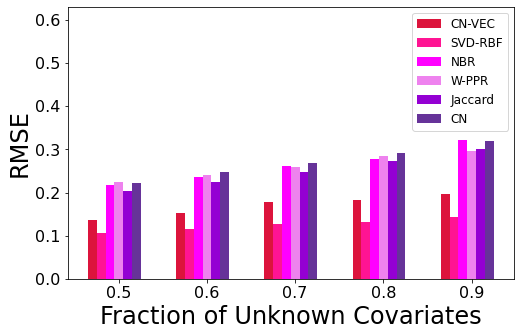

In [17]:
plt.figure(figsize=(8,5))
# plt.title('SBM', fontsize=24)
plt.xlabel('Fraction of Unknown Covariates', fontsize=24)
plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.63)
width = 0.01
plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='crimson')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='deeppink')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='fuchsia')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='violet')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='darkviolet')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='rebeccapurple');
plt.legend(fontsize=12);

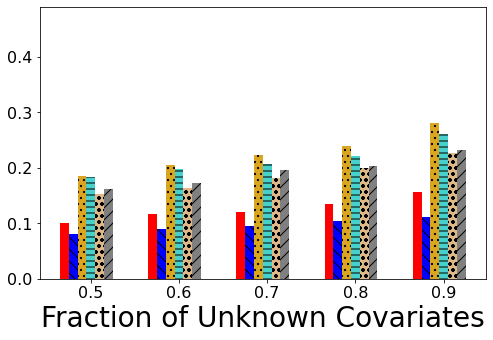

In [56]:
plt.figure(figsize=(8,5))
# plt.title('SBM')
plt.xlabel('Fraction of Unknown Covariates', fontsize=28)
# plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.49)
width = 0.01
plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='r')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='b', hatch='\\\\')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='goldenrod', hatch='..')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='mediumturquoise', hatch='--')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='burlywood', hatch='oo')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='gray', hatch='//');
# plt.legend();

### Mixed-membership Stochastic Blockmodel (MMSB)

In [44]:
Z = np.random.dirichlet(np.ones(5) / 5, (n,))

In [45]:
Z.sum(1)

array([1., 1., 1., ..., 1., 1., 1.])

In [46]:
theta = np.ones((d,d)) * 0.1
np.fill_diagonal(theta, 1)

In [47]:
rho = 0.1
P = rho * Z @ theta @ Z.T

In [48]:
A = csr_matrix(np.random.binomial(1, P, (n,n)).astype(float))
A.setdiag(0)
A.eliminate_zeros()

C:\Users\Liza\anaconda3\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [49]:
beta = np.random.normal(0, 1, (d,1))
beta = beta / np.linalg.norm(beta)
X = (Z @ beta).flatten() + np.random.normal(0, .1, (n,))

#### Available algorithms

In [50]:
k=10
shares = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

In [99]:
grid = np.linspace(0.01, 1, 100)

In [100]:
RMSE_SVD_RBFs = np.zeros((100, 5))
for i, theta in enumerate(grid):
    rmse = []
    for share in shares:
        S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
        RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, theta*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
        rmse.append(RMSE_SVD_RBF)
    RMSE_SVD_RBFs[i] = rmse

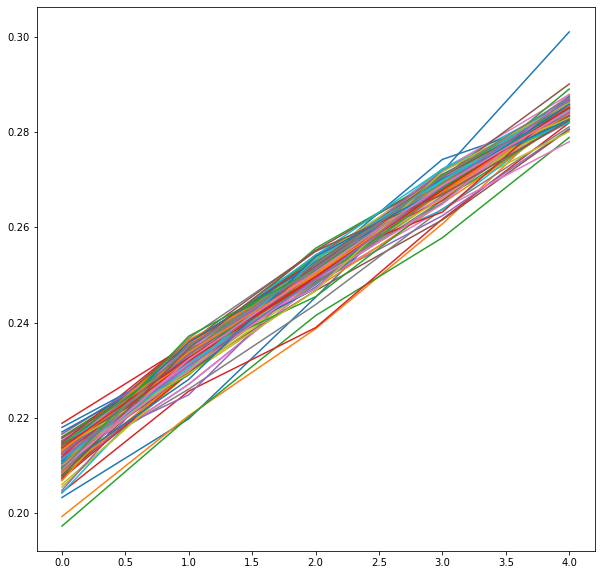

In [107]:
plt.figure(figsize=(10,10))
for line in RMSE_SVD_RBFs[2:]:
    plt.plot(line)

In [51]:
RMSE_NBRs = []
RMSE_W_PPRs = []
RMSE_Jaccards = []
RMSE_CNs = []
RMSE_SVD_RBFs = []
RMSE_CN_VECs = []
for share in shares:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_NBR = mean_squared_error(X, NBR(X, A, S), squared=False)
    RMSE_NBRs.append(RMSE_NBR)
#     print('NBR done')
    RMSE_W_PPR = mean_squared_error(X, W_PPR(X, A, S, k), squared=False)
    RMSE_W_PPRs.append(RMSE_W_PPR)
#     print('W_PPR done')
    RMSE_Jaccard = mean_squared_error(X, Jaccard(X, A, S, k), squared=False)
    RMSE_Jaccards.append(RMSE_Jaccard)
#     print('Jaccard done')
    RMSE_CN = mean_squared_error(X, CN(X, A, S, k), squared=False)
    RMSE_CNs.append(RMSE_CN)
#     print('CN done')
    RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, 0.01*(np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
    RMSE_SVD_RBFs.append(RMSE_SVD_RBF)
#     print('SVD RBF done')
    RMSE_CN_VEC = mean_squared_error(X, CN_VEC(X, A, S, k), squared=False)
    RMSE_CN_VECs.append(RMSE_CN_VEC)
# #     print('CN VEC done')
    print(share, 'done')

  0%|          | 0/1250 [00:00<?, ?it/s]

0.5 done


  0%|          | 0/1500 [00:00<?, ?it/s]

0.6 done


  0%|          | 0/1750 [00:00<?, ?it/s]

0.7 done


  0%|          | 0/2001 [00:00<?, ?it/s]

0.8 done


  0%|          | 0/2251 [00:00<?, ?it/s]

0.9 done


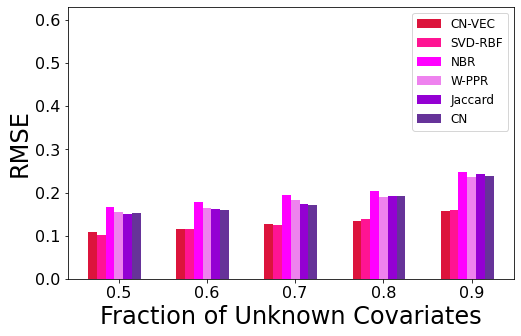

In [52]:
plt.figure(figsize=(8,5))
# plt.title('MMSB', fontsize=24)
plt.xlabel('Fraction of Unknown Covariates', fontsize=24)
plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.63)
width = 0.01
plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='crimson')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='deeppink')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='fuchsia')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='violet')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='darkviolet')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='rebeccapurple');
plt.legend(fontsize=12);

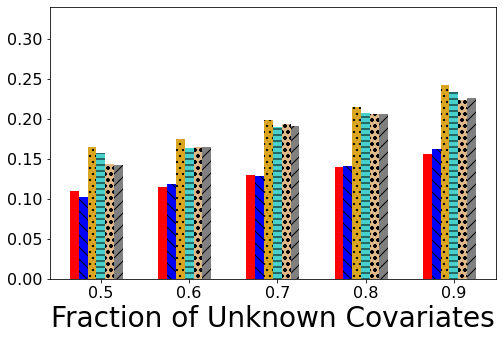

In [46]:
plt.figure(figsize=(8,5))
# plt.title('MMSB')
plt.xlabel('Fraction of Unknown Covariates', fontsize=28)
# plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.34)
width = 0.01
plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='r')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='b', hatch='\\\\')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='goldenrod', hatch='..')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='mediumturquoise', hatch='--')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='burlywood', hatch='oo')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='gray', hatch='//');
# plt.legend();

### Random Dot Product Graph model (RDPG)

In [ ]:
Z = [np.random.normal(i, np.sqrt(0.1), size=(n, d)) for i in range(1,6)]

In [114]:
rho = 0.1
P = np.zeros((n,n))
for i in range(n):
    P[i] = np.min(np.stack((np.ones_like(Z @ Z[i]), np.max(np.stack((np.zeros_like(Z @ Z[i]), Z @ Z[i])), axis=0))), axis=0)

In [115]:
A = csr_matrix(np.random.binomial(1, P, (n,n)).astype(float))
A.setdiag(0)
A.eliminate_zeros()

In [116]:
beta = np.random.normal(0, 1, (d,1))
beta = beta / np.linalg.norm(beta)
X = (Z @ beta).flatten() + np.random.normal(0, .1, (n,))

#### Available algorithms

In [101]:
k=10
shares = np.array([0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
RMSE_NBRs = []
RMSE_W_PPRs = []
RMSE_Jaccards = []
RMSE_CNs = []
RMSE_SVD_RBFs = []
RMSE_CN_VECs = []
for share in [0.5, 0.6, 0.7, 0.8, 0.9]:
    S = np.random.choice(np.arange(n), size=int(n*(1-share)), replace=False)
    RMSE_NBR = mean_squared_error(X, NBR(X, A, S), squared=False)
    RMSE_NBRs.append(RMSE_NBR)
#     print('NBR done')
    RMSE_W_PPR = mean_squared_error(X, W_PPR(X, A, S, k), squared=False)
    RMSE_W_PPRs.append(RMSE_W_PPR)
#     print('W_PPR done')
    RMSE_Jaccard = mean_squared_error(X, Jaccard(X, A, S, k), squared=False)
    RMSE_Jaccards.append(RMSE_Jaccard)
#     print('Jaccard done')
    RMSE_CN = mean_squared_error(X, CN(X, A, S, k), squared=False)
    RMSE_CNs.append(RMSE_CN)
#     print('CN done')
    RMSE_SVD_RBF = mean_squared_error(X, SVD_RBF(X, A, S, (np.log(n))**(3/d) / n**(1 / 2 / (d+1)), d), squared=False)
    RMSE_SVD_RBFs.append(RMSE_SVD_RBF)
#     print('SVD RBF done')
#     RMSE_CN_VEC = mean_squared_error(X, CN_VEC(X, A, S, k), squared=False)
#     RMSE_CN_VECs.append(RMSE_CN_VEC)
# #     print('CN VEC done')
    print(share, 'done')

In [ ]:
plt.figure(figsize=(8,4))
plt.title('MMSB')
plt.xlabel('Fraction of Unknown Covariates', fontsize=24)
plt.ylabel('RMSE', fontsize=24)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.ylim(0, 0.6)
width = 0.01
# plt.bar(x=shares-3*width, height=RMSE_CN_VECs, width=width, label='CN-VEC', color='r')
plt.bar(x=shares-2*width, height=RMSE_SVD_RBFs, width=width, label='SVD-RBF', color='b', hatch='\\\\')
plt.bar(x=shares-width, height=RMSE_NBRs, width=width, label='NBR', color='goldenrod', hatch='..')
plt.bar(x=shares, height=RMSE_W_PPRs, width=width, label='W-PPR', color='mediumturquoise', hatch='--')
plt.bar(x=shares+width, height=RMSE_Jaccards, width=width, label='Jaccard', color='burlywood', hatch='oo')
plt.bar(x=shares+2*width, height=RMSE_CNs, width=width, label='CN', color='gray', hatch='//');
# plt.legend();